In [1]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import subprocess
import sys

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler('/home/dee/dev/deptrim-major/deptrim-experiments/calculations.log')
file_handler.setLevel(logging.INFO)
logger.addHandler(file_handler)

original_jar_path = "original/"
original_deps_path = "/original/compile-scope-dependencies/dependency/"
spl_deps_path = "deptrim/libs-specialized/"
percent_reduction = []

In [3]:
def get_class_file_sizes_in_jar(project, path, jar):
    logger.info(f'CDing into {(project["path"] + path)}')
    os.chdir(project["path"] + path)
    cmd = "jar tvf " + jar + "|grep \"\.class\""
    logger.info(f"Running {cmd}")
    process = subprocess.Popen(cmd,
                               shell=True,
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    classes = stdout.decode("utf-8")
    return classes

In [4]:
def get_list_of_sizes(classes):
    # just get the size in bytes
    sizes = re.sub(r"(\d+\s)(.+)", r"\1", classes)
    # replace new lines with commas
    sizes = re.sub(r"\n", ",", sizes)
    # remove whitespaces
    sizes = re.sub(r"\s", "", sizes)
    # remove the last comma
    sizes = sizes[:-1].strip()
    # convert this string into a list with integers 
    mylist = [int(x) for x in sizes.split(',') if x.strip().isdigit()]
    # return the list
    logger.info(f'Number of .class files: {len(mylist)}')
    return mylist

In [5]:
def process_project(project):
    logger.info(f'Processing project {project["name"]}')
    logger.info(f'dependencies [original]: {len(project["deps_orig"])}')
    logger.info(f'dependencies [bloated]: {len(project["deps_bloated"])}')
    logger.info(f'dependencies [specialized]: {len(project["deps_spl"])}')
    logger.info(f'dependencies [non-specialized]: {len(project["deps_non_spl"])}')
    logger.info("-------------------")
    
    # PROJECT CLASSES AND SIZE
    logger.info("project jar")
    classes_project_jar = get_class_file_sizes_in_jar(project, original_jar_path, project["jar"])
    sizes_project_jar = get_list_of_sizes(classes_project_jar)
    sum_sizes_project_jar = sum(sizes_project_jar)
    logger.info(f'PROJECT JAR SIZE: {(sum_sizes_project_jar/1024)} KB')
    project["project_size"] = (sum_sizes_project_jar/1024)
    
    logger.info("-------------------")

    # ORIGINAL DEPS CLASSES AND SIZE (INCLUDES BLOATED DEPS)
    size_original_deps = 0
    total_classes_original = 0
    logger.info("original dependency jars")
    for i in range(len(project["deps_orig"])):
        this_dep_jar = project["deps_orig"][i]
        logger.info(f'Calculating size for {this_dep_jar}')
        dep_jar_classes = get_class_file_sizes_in_jar(project, original_deps_path, this_dep_jar)
        dep_jar_sizes = get_list_of_sizes(dep_jar_classes)
        sum_dep_jar_sizes = sum(dep_jar_sizes)
        project[this_dep_jar] = {}
        project[this_dep_jar]["original"] = {"classes": len(dep_jar_sizes), "size": sum_dep_jar_sizes}
        total_classes_original += len(dep_jar_sizes)
        logger.info(f'Size: {sum_dep_jar_sizes/1024} KB')
        size_original_deps += sum_dep_jar_sizes
        logger.info("-------------------")

    logger.info(f'TOTAL SIZE OF ORIGINAL DEPENDENCIES IN {project["name"]}: {size_original_deps/1024} KB')

    logger.info("-------------------")

    # SPECIALIZED DEPS CLASSES AND SIZE
    size_specialized_deps = 0
    total_classes_specialized = 0
    logger.info("specialized dependency jars")
    for i in range(len(project["deps_spl"])):
        this_dep_jar = project["deps_spl"][i]
        logger.info(f'Calculating size for {this_dep_jar}')
        dep_jar_classes = get_class_file_sizes_in_jar(project, spl_deps_path, this_dep_jar)
        dep_jar_sizes = get_list_of_sizes(dep_jar_classes)
        sum_dep_jar_sizes = sum(dep_jar_sizes)
        project[this_dep_jar]["spl"] = {"classes": len(dep_jar_sizes), "size": sum_dep_jar_sizes}
        total_classes_specialized += len(dep_jar_sizes)
        logger.info(f'Size: {sum_dep_jar_sizes/1024} KB')
        size_specialized_deps += sum_dep_jar_sizes
        logger.info("-------------------")
        
    logger.info(f'TOTAL SIZE OF SPECIALIZED DEPENDENCIES IN {project["name"]}: {size_specialized_deps/1024} KB')
        
    logger.info("-------------------")
    
    # DEPS SPECIALIZED BUT NOT INCLUDED
    unsucc_specialized_deps = 0
    classes_removed_from_unsucc_deps = 0
    logger.info("unsuccessfully specialized jars")
    for i in range(len(project["deps_non_spl"])):
        this_dep_jar = project["deps_non_spl"][i]
        logger.info(f'Calculating number of classes in unsucc specialized dep {this_dep_jar}')
        dep_jar_classes = get_class_file_sizes_in_jar(project, spl_deps_path, this_dep_jar)
        dep_jar_sizes = get_list_of_sizes(dep_jar_classes)
        logger.info(f'Classes in unsucc dep: {len(dep_jar_sizes)}')
        if len(dep_jar_sizes) != 0:
            classes_removed_from_this_unsucc_dep = project[this_dep_jar]["original"]["classes"] - len(dep_jar_sizes)
        else:
            classes_removed_from_this_unsucc_dep = 0
        project[this_dep_jar]["classes_removed"] = classes_removed_from_this_unsucc_dep
        logger.info(f'CLASSES REMOVED FROM UNSUCC DEP {this_dep_jar}: {classes_removed_from_this_unsucc_dep}')
        unsucc_specialized_deps += len(dep_jar_sizes)
        classes_removed_from_unsucc_deps += classes_removed_from_this_unsucc_dep
        logger.info("-------------------")
    project["unsuccessfully_spl_classes"] = unsucc_specialized_deps
    project["classes_removed_from_unsucc_deps"] = classes_removed_from_unsucc_deps
        
    logger.info("-------------------")
    
    # NON-SPECIALIZED DEPS CLASSES AND SIZE (TUDs, FAILING CASES)
    size_non_specialized_deps = 0
    total_classes_non_specialized = 0
    logger.info("non-specialized dependency jars")
    for i in range(len(project["deps_non_spl"])):
        this_dep_jar = project["deps_non_spl"][i]
        logger.info(f'Calculating size for {this_dep_jar}')
        dep_jar_classes = get_class_file_sizes_in_jar(project, original_deps_path, this_dep_jar)
        dep_jar_sizes = get_list_of_sizes(dep_jar_classes)
        sum_dep_jar_sizes = sum(dep_jar_sizes)
        project[this_dep_jar]["non_spl"] = {"classes": len(dep_jar_sizes), "size": sum_dep_jar_sizes}
        total_classes_non_specialized += len(dep_jar_sizes)
        logger.info(f'Size: {sum_dep_jar_sizes/1024} KB')
        size_non_specialized_deps += sum_dep_jar_sizes
        logger.info("-------------------")
        
    logger.info(f'TOTAL SIZE OF NON-SPECIALIZED DEPENDENCIES IN {project["name"]}: {size_non_specialized_deps/1024} KB')
    
    logger.info("-------------------")
    
    # BLOATED DEPS CLASSES AND SIZE
    bloated_deps_classes = 0
    size_bloated_deps = 0
    logger.info("bloated dependency jars")
    for i in range(len(project["deps_bloated"])):
        this_dep_jar = project["deps_bloated"][i]
        logger.info(f'Calculating number of classes in bloated dep {this_dep_jar}')
        dep_jar_classes = get_class_file_sizes_in_jar(project, original_deps_path, this_dep_jar)
        dep_jar_sizes = get_list_of_sizes(dep_jar_classes)
        logger.info(f'Classes: {len(dep_jar_sizes)}')
        bloated_deps_classes += len(dep_jar_sizes)
        sum_dep_jar_sizes = sum(dep_jar_sizes)
        size_bloated_deps += sum_dep_jar_sizes
        logger.info("-------------------")
    project["bloated"] = {}
    project["bloated"]["classes"] = bloated_deps_classes
    project["bloated"]["size"] = size_bloated_deps
    
    logger.info(f'TOTAL SIZE OF BLOATED DEPENDENCIES IN {project["name"]}: {size_bloated_deps/1024} KB')
    
    logger.info("-------------------")
    
    # AGGREGATES
    
    logger.info("================================")
    logger.info(f'PROJECT CLASSES IN {project["name"]}: {project["project_classes"]}')
    project["total_classes_orig_deps"] = total_classes_original
    logger.info(f'ORIG DEP CLASSES IN {project["name"]}: {project["total_classes_orig_deps"]}')
    
    class_reduction = (total_classes_original - (total_classes_specialized + total_classes_non_specialized))
    logger.info(f'CLASSES REMOVED IN {project["name"]}: {class_reduction}')
    project["class_reduction"] = class_reduction

    original_project = sum_sizes_project_jar + size_original_deps
    logger.info(f'PROJECT + ORIGINAL IN {project["name"]}: {original_project/1024} KB')
    
    specialized_project = sum_sizes_project_jar + size_specialized_deps + size_non_specialized_deps
    logger.info(f'PROJECT + SPECIALIZED IN {project["name"]}: {specialized_project/1024} KB')
    
    project["total_original_size"] = original_project/1024
    project["total_final_size"] = specialized_project/1024
    
    reduction = ((original_project - specialized_project) / original_project) * 100
    
    logger.info(f'CLASSES IN BLOATED DEPS OF {project["name"]}: {project["bloated"]["classes"]}')
    logger.info(f'CLASSES IN UNSUCC SPL DEPS OF {project["name"]}: {project["unsuccessfully_spl_classes"]}')
    logger.info(f'CLASSES REMOVED FROM UNSUCC SPL DEPS OF {project["name"]}: {project["classes_removed_from_unsucc_deps"]}')

    logger.info(f'PERCENT REDUCTION IN {project["name"]}: {reduction}')
    percent_reduction.append({"project": project["name"], 
                              "orig_package": original_project,
                              "spl_package": specialized_project,
                              "reduction": reduction})
    
    project["percentage_reduction"] = reduction

## TST

In [6]:
template = {
    "name": "",
    "path": "",
    "jar": "",
    "project_classes": 0,
    "deps_orig": [],
    "deps_spl": [],
    "deps_non_spl": [],
    "deps_bloated": []
}

In [7]:
classgraph = {
    "name": "classgraph",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/classgraph/",
    "jar": "classgraph-4.8.154.jar",
    "project_classes": 261,
    "deps_orig": ["jvm-driver-9.4.2.jar",
                  "narcissus-1.0.7.jar"
                 ],
    "deps_spl": ["jvm-driver-9.4.2.jar",
                  "narcissus-1.0.7.jar"
                ],
    "deps_non_spl": [],
    "deps_bloated": []
}

In [8]:
commons_validator = {
    "name": "commons-validator",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/commons-validator/",
    "jar": "commons-validator-1.7.jar",
    "project_classes": 64,
    "deps_orig": ["commons-beanutils-1.9.4.jar",
                  "commons-collections-3.2.2.jar",
                  "commons-digester-2.1.jar",
                  "commons-logging-1.2.jar"
                 ],
    "deps_spl": ["commons-beanutils-1.9.4.jar",
                 "commons-collections-3.2.2.jar",
                 "commons-digester-2.1.jar",
                 "commons-logging-1.2.jar"
                ],
    "deps_non_spl": [],
    "deps_bloated": []
}

In [9]:
corenlp = {
    "name": "CoreNLP",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/CoreNLP/",
    "jar": "stanford-corenlp-4.5.1.jar",
    "project_classes": 3932,
    "deps_orig": ["AppleJavaExtensions-1.4.jar",
                  "ejml-dsparse-0.39.jar",
                  "istack-commons-runtime-3.0.7.jar",
                  "jaxb-impl-2.4.0-b180830.0438.jar",
                  "lucene-analyzers-common-7.5.0.jar",
                  "protobuf-java-3.19.2.jar",
                  "xml-apis-1.3.03.jar",
                  "commons-lang3-3.3.1.jar",
                  "ejml-fdense-0.39.jar",
                  "javax.activation-api-1.2.0.jar",
                  "joda-time-2.10.5.jar",
                  "lucene-core-7.5.0.jar",
                  "serializer-2.7.2.jar",
                  "xom-1.3.7.jar",
                  "ejml-cdense-0.39.jar",
                  "ejml-fsparse-0.39.jar",
                  "javax.json-1.0.4.jar",
                  "jollyday-0.4.9.jar",
                  "lucene-queries-7.5.0.jar",
                  "slf4j-api-1.7.12.jar",
                  "ejml-core-0.39.jar",
                  "ejml-simple-0.39.jar",
                  "javax.servlet-api-3.0.1.jar",
                  "json-simple-1.1.1.jar",
                  "lucene-queryparser-7.5.0.jar",
                  "xalan-2.7.2.jar",
                  "ejml-ddense-0.39.jar",
                  "ejml-zdense-0.39.jar",
                  "jaxb-api-2.4.0-b180830.0359.jar",
                  "jsr305-3.0.2.jar",
                  "lucene-sandbox-7.5.0.jar",
                  "xercesImpl-2.8.0.jar"],
    "deps_spl": ["AppleJavaExtensions-1.4.jar",
                 "ejml-dsparse-0.39.jar",
                 "istack-commons-runtime-3.0.7.jar",
                 "joda-time-2.10.5.jar",
                 "lucene-core-7.5.0.jar",
                 "xalan-2.7.2.jar",
                 "commons-lang3-3.3.1.jar",
                 "ejml-fdense-0.39.jar",
                 "javax.activation-api-1.2.0.jar",
                 "jollyday-0.4.9.jar",
                 "lucene-queryparser-7.5.0.jar",
                 "xercesImpl-2.8.0.jar",
                 "ejml-cdense-0.39.jar",
                 "ejml-fsparse-0.39.jar",
                 "javax.servlet-api-3.0.1.jar",
                 "json-simple-1.1.1.jar",
                 "protobuf-java-3.19.2.jar",
                 "xml-apis-1.3.03.jar",
                 "ejml-core-0.39.jar",
                 "ejml-simple-0.39.jar",
                 "jaxb-api-2.4.0-b180830.0359.jar",
                 "jsr305-3.0.2.jar",
                 "serializer-2.7.2.jar",
                 "xom-1.3.7.jar",
                 "ejml-ddense-0.39.jar",
                 "ejml-zdense-0.39.jar",
                 "jaxb-impl-2.4.0-b180830.0438.jar",
                 "lucene-analyzers-common-7.5.0.jar",
                 "slf4j-api-1.7.12.jar"
                ],
    "deps_non_spl": ["javax.json-1.0.4.jar"],
    "deps_bloated": ["lucene-queries-7.5.0.jar",
                     "lucene-sandbox-7.5.0.jar"]
}

In [10]:
guice = {
    "name": "guice/core",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/guice/core/",
    "jar": "original-guice-5.1.0.jar",
    "project_classes": 460,
    "deps_orig": ["aopalliance-1.0.jar",
                  "checker-qual-3.5.0.jar",
                  "failureaccess-1.0.1.jar",
                  "j2objc-annotations-1.3.jar",
                  "jsr305-3.0.1.jar",
                  "asm-9.2.jar",
                  "error_prone_annotations-2.3.4.jar",
                  "guava-30.1-jre.jar",
                  "javax.inject-1.jar",
                  "listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar"
                 ],
    "deps_spl": ["aopalliance-1.0.jar",
                 "asm-9.2.jar",
                 "checker-qual-3.5.0.jar",
                 "error_prone_annotations-2.3.4.jar",
                 "guava-30.1-jre.jar",
                 "j2objc-annotations-1.3.jar",
                 "jsr305-3.0.1.jar"
                ],
    "deps_non_spl": ["failureaccess-1.0.1.jar",
                     "javax.inject-1.jar"
                    ],
    "deps_bloated": ["listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar"]
}

In [11]:
httpcomponents_client = {
    "name": "httpcomponents-client/httpclient5",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/httpcomponents-client/httpclient5/",
    "jar": "httpclient5-5.2.1.jar",
    "project_classes": 493,
    "deps_orig": ["conscrypt-openjdk-uber-2.5.2.jar",
                  "dec-0.1.2.jar",
                  "httpcore5-5.2.jar",
                  "httpcore5-h2-5.2.jar",
                  "slf4j-api-1.7.36.jar"
                 ],
    "deps_spl": ["conscrypt-openjdk-uber-2.5.2.jar",
                 "httpcore5-5.2.jar",
                 "httpcore5-h2-5.2.jar",
                 "slf4j-api-1.7.36.jar"
                ],
    "deps_non_spl": ["dec-0.1.2.jar"],
    "deps_bloated": []
}

In [12]:
immutables = {
    "name": "immutables/gson",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/immutables/gson/",
    "jar": "gson-2.9.3.jar",
    "project_classes": 31,
    "deps_orig": ["gson-2.8.8.jar",
                  "javax.ws.rs-api-2.0.jar"
                 ],
    "deps_spl": ["gson-2.8.8.jar",
                 "javax.ws.rs-api-2.0.jar"],
    "deps_non_spl": [],
    "deps_bloated": []
}

In [13]:
jimfs = {
    "name": "jimfs",
    "path": "/home/dee/dev/deptrim-major/execution-results/jimfs/",
    "jar": "jimfs-1.2.jar",
    "project_classes": 124,
    "deps_orig": ["auto-service-annotations-1.0-rc7.jar",
                  "error_prone_annotations-2.3.4.jar",
                  "guava-30.1-android.jar",
                  "j2objc-annotations-1.3.jar",
                  "listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar",
                  "checker-compat-qual-2.5.5.jar",
                  "failureaccess-1.0.1.jar",
                  "icu4j-68.2.jar",
                  "jsr305-3.0.2.jar"
                 ],
    "deps_spl": ["checker-compat-qual-2.5.5.jar",
                 "jsr305-3.0.2.jar",
                 "error_prone_annotations-2.3.4.jar",
                 "icu4j-68.2.jar",
                 "j2objc-annotations-1.3.jar",
                 "guava-30.1-android.jar"
                ],
    "deps_non_spl": ["auto-service-annotations-1.0-rc7.jar",
                     "failureaccess-1.0.1.jar"],
    "deps_bloated": ["listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar"]
}

In [14]:
pdfbox = {
    "name": "pdfbox/pdfbox",
    "path": "/home/dee/dev/deptrim-major/execution-results/pdfbox_pdfbox/",
    "jar": "pdfbox-3.0.0-SNAPSHOT.jar",
    "project_classes": 754,
    "deps_orig": ["bcmail-jdk18on-1.72.jar",
                  "bcpkix-jdk18on-1.72.jar",
                  "bcprov-jdk18on-1.72.jar",
                  "bcutil-jdk18on-1.72.jar",
                  "commons-logging-1.2.jar",
                  "fontbox-3.0.0-SNAPSHOT.jar",
                  "io-3.0.0-SNAPSHOT.jar"
                 ],
    "deps_spl": ["bcpkix-jdk18on-1.72.jar",
                 "bcprov-jdk18on-1.72.jar",
                 "bcutil-jdk18on-1.72.jar",
                 "commons-logging-1.2.jar",
                 "fontbox-3.0.0-SNAPSHOT.jar",
                 "io-3.0.0-SNAPSHOT.jar"
                ],
    "deps_non_spl": [],
    "deps_bloated": ["bcmail-jdk18on-1.72.jar"]
}

In [15]:
pf4j = {
    "name": "pf4j/pf4j",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/pf4j/pf4j/",
    "jar": "pf4j-3.8.0.jar",
    "project_classes": 93,
    "deps_orig": ["asm-9.1.jar",
                  "java-semver-0.9.0.jar",
                  "slf4j-api-1.7.30.jar"
                 ],
    "deps_spl": ["asm-9.1.jar",
                 "slf4j-api-1.7.30.jar"
                ],
    "deps_non_spl": ["java-semver-0.9.0.jar"],
    "deps_bloated": []
}

In [16]:
recaf = {
    "name": "Recaf",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/with-workload/Recaf/",
    "jar": "recaf-2.21.13.jar",
    "project_classes": 538,
    "deps_orig": ["annotations-3.0.1.jar",
                  "commons-io-2.11.0.jar",
                 "javassist-3.28.0-GA.jar",
                 "jregex-1.2_01.jar",
                 "reactfx-2.0-M5.jar",
                 "args4j-2.33.jar",
                 "commons-lang3-3.11.jar",
                 "javax.inject-1.jar",
                 "jsoup-1.14.3.jar",
                 "reflectasm-1.11.9.jar",
                 "asm-9.2.jar",
                 "cssparser-0.9.29.jar",
                 "jcip-annotations-1.0.jar",
                 "jsr305-3.0.2.jar",
                 "richtextfx-0.10.6.jar",
                 "asm-analysis-9.2.jar",
                 "directories-12.jar",
                 "jgrapht-core-1.0.1.jar",
                 "listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar",
                 "sac-1.3.jar",
                 "asm-commons-9.2.jar",
                 "error_prone_annotations-2.11.0.jar",
                 "jline-3.19.0.jar",
                 "logback-classic-1.2.10.jar",
                 "SimAnalyzer-1.6.0.jar",
                 "asm-tree-9.2.jar",
                 "failureaccess-1.0.1.jar",
                 "jline-builtins-3.21.0.jar",
                 "logback-core-1.2.3.jar",
                 "slf4j-api-1.7.30.jar",
                 "asm-util-9.2.jar",
                 "flowless-0.6.3.jar",
                 "jline-reader-3.21.0.jar",
                 "minimal-json-0.9.5.jar",
                 "undofx-2.1.0.jar",
                 "CAFED00D-1.9.6.jar",
                 "forgeflower-1.5.498.29.jar",
                 "jline-style-3.21.0.jar",
                 "picocli-4.6.3.jar",
                 "wellbehavedfx-0.3.3.jar",
                 "cfr-0.152.jar",
                 "guava-31.1-jre.jar",
                 "jline-terminal-3.21.0.jar",
                 "picocli-shell-jline3-4.6.3.jar",
                 "checker-qual-3.12.0.jar",
                 "j2objc-annotations-1.3.jar",
                 "jline-terminal-jna-3.21.0.jar",
                 "plugface-core-0.7.1.jar",
                 "commonmark-0.18.2.jar",
                 "javaparser-core-3.24.2.jar",
                 "jna-5.9.0.jar",
                 "procyon-compilertools-0.6.0.jar",
                 "commons-codec-1.15.jar",
                 "javaparser-symbol-solver-core-3.24.2.jar",
                 "jphantom-1.4.3.jar",
                 "procyon-core-0.6.0.jar"
                 ],
    "deps_spl": ["annotations-3.0.1.jar",
                 "checker-qual-3.12.0.jar",
                 "error_prone_annotations-2.11.0.jar",
                 "javaparser-symbol-solver-core-3.24.2.jar",
                 "jline-reader-3.21.0.jar",
                 "logback-classic-1.2.10.jar",
                 "procyon-core-0.6.0.jar",
                 "args4j-2.33.jar",
                 "commonmark-0.18.2.jar",
                 "flowless-0.6.3.jar",
                 "javassist-3.28.0-GA.jar",
                 "jline-terminal-3.21.0.jar",
                 "logback-core-1.2.3.jar",
                 "reactfx-2.0-M5.jar",
                 "asm-analysis-9.2.jar",
                 "commons-codec-1.15.jar",
                 "forgeflower-1.5.498.29.jar",
                 "javax.inject-1.jar",
                 "jphantom-1.4.3.jar",
                 "picocli-4.6.3.jar",
                 "richtextfx-0.10.6.jar",
                 "asm-commons-9.2.jar",
                 "commons-io-2.11.0.jar",
                 "guava-31.1-jre.jar",
                 "jgrapht-core-1.0.1.jar",
                 "jregex-1.2_01.jar",
                 "picocli-shell-jline3-4.6.3.jar",
                 "SimAnalyzer-1.6.0.jar",
                 "asm-util-9.2.jar",
                 "cssparser-0.9.29.jar",
                 "j2objc-annotations-1.3.jar",
                 "jline-3.19.0.jar",
                 "jsoup-1.14.3.jar",
                 "plugface-core-0.7.1.jar",
                 "slf4j-api-1.7.30.jar",
                 "cfr-0.152.jar",
                 "directories-12.jar",
                 "javaparser-core-3.24.2.jar",
                 "jline-builtins-3.21.0.jar",
                 "jsr305-3.0.2.jar",
                 "procyon-compilertools-0.6.0.jar"
                ],
    "deps_non_spl": ["asm-9.2.jar",
                     "asm-tree-9.2.jar",
                     "CAFED00D-1.9.6.jar",
                     "minimal-json-0.9.5.jar",
                     "reflectasm-1.11.9.jar",
                     "sac-1.3.jar",
                     "undofx-2.1.0.jar",
                     "wellbehavedfx-0.3.3.jar"
                    ],
    "deps_bloated": ["commons-lang3-3.11.jar",
                     "failureaccess-1.0.1.jar",
                     "jcip-annotations-1.0.jar",
                     "jline-style-3.21.0.jar",
                     "jline-terminal-jna-3.21.0.jar",
                     "jna-5.9.0.jar",
                     "listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar"
                    ]
}

In [17]:
scribejava = {
    "name": "scribejava/core",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/scribejava/scribejava-core/",
    "jar": "scribejava-core-8.3.2.jar",
    "project_classes": 116,
    "deps_orig": ["commons-codec-1.15.jar",
                  "jackson-core-2.13.4.jar",
                  "jakarta.activation-2.0.1.jar",
                  "jaxb-api-2.3.0.jar",
                  "jackson-annotations-2.13.4.jar",
                  "jackson-databind-2.13.4.jar",
                  "jakarta.xml.bind-api-3.0.1.jar",
                  "scribejava-java8-8.3.2.jar"],
    "deps_spl": ["commons-codec-1.15.jar",
                 "jackson-databind-2.13.4.jar",
                 "jackson-annotations-2.13.4.jar",
                 "jakarta.xml.bind-api-3.0.1.jar",
                 "jackson-core-2.13.4.jar",
                 "jaxb-api-2.3.0.jar"
                ],
    "deps_non_spl": ["scribejava-java8-8.3.2.jar"],
    "deps_bloated": ["jakarta.activation-2.0.1.jar"]
}

In [18]:
tablesaw = {
    "name": "tablesaw/json",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/tablesaw/json/",
    "jar": "tablesaw-json-0.43.1.jar",
    "project_classes": 7,
    "deps_orig": ["commons-lang3-3.9.jar",
                  "jackson-annotations-2.13.2.jar",
                  "jackson-databind-2.13.2.1.jar",
                  "json-base-1.0.0.jar",
                  "minimal-json-0.9.5.jar",
                  "commons-text-1.8.jar",
                  "jackson-core-2.13.2.jar",
                  "jackson-datatype-jsr310-2.13.2.jar",
                  "json-flattener-0.8.1.jar"
                 ],
    "deps_spl": ["commons-lang3-3.9.jar",
                 "commons-text-1.8.jar",
                 "jackson-core-2.13.2.jar",
                 "jackson-databind-2.13.2.1.jar",
                 "jackson-datatype-jsr310-2.13.2.jar",
                 "json-base-1.0.0.jar",
                 "json-flattener-0.8.1.jar"
                ],
    "deps_non_spl": ["jackson-annotations-2.13.2.jar",
                     "minimal-json-0.9.5.jar"],
    "deps_bloated": []
}

In [19]:
tika = {
    "name": "tika/core",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/tika/tika-core/",
    "jar": "tika-core-2.6.0.jar",
    "project_classes": 435,
    "deps_orig": ["commons-io-2.11.0.jar",
                  "slf4j-api-2.0.3.jar"
                 ],
    "deps_spl": ["commons-io-2.11.0.jar",
                  "slf4j-api-2.0.3.jar"
                ],
    "deps_non_spl": [],
    "deps_bloated": []
}

In [20]:
undertow = {
    "name": "undertow/core",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/tst/undertow/core/",
    "jar": "undertow-core-2.2.21.Final.jar",
    "project_classes": 1581,
    "deps_orig": ["jboss-logging-3.4.1.Final.jar",
                  "jboss-threads-3.1.0.Final.jar",
                  "wildfly-client-config-1.0.1.Final.jar",
                  "wildfly-common-1.5.4.Final.jar",
                  "xnio-api-3.8.7.Final.jar"
                ],
    "deps_spl": ["jboss-logging-3.4.1.Final.jar",
                 "jboss-threads-3.1.0.Final.jar",
                 "wildfly-client-config-1.0.1.Final.jar",
                 "wildfly-common-1.5.4.Final.jar",
                 "xnio-api-3.8.7.Final.jar"
                   ],
    "deps_non_spl": [],
    "deps_bloated": []
}

In [21]:
projects_tst = [classgraph,
                commons_validator,
                corenlp,
                guice,
                httpcomponents_client,
                immutables,
                jimfs,
                pdfbox,
                pf4j,
                recaf,
                scribejava,
                tablesaw,
                tika,
                undertow]
len(projects_tst)

14

In [22]:
for p in range(len(projects_tst)):
    process_project(projects_tst[p])
    logger.info("================================================================")

In [23]:
 with open("/home/dee/dev/deptrim-major/deptrim-experiments/TSTs.json", "a") as outfile:
        json.dump(projects_tst, outfile, indent=2)

## PST

In [24]:
template = {
    "name": "",
    "path": "",
    "jar": "",
    "project_classes": 0,
    "deps_orig": [],
    "deps_spl": [],
    "deps_non_spl": [],
    "deps_bloated": []
}

In [25]:
checkstyle = {
    "name": "checkstyle",
    "path": "/home/dee/dev/deptrim-major/execution-results/checkstyle/",
    "jar": "checkstyle-10.5.0.jar",
    "project_classes": 863,
    "deps_orig": ["antlr4-runtime-4.11.1.jar",
                  "commons-collections-3.2.2.jar",
                  "guava-31.1-jre.jar",
                  "j2objc-annotations-1.3.jar",
                  "picocli-4.7.0.jar",
                  "xmlresolver-4.4.3-data.jar",
                  "checker-qual-3.27.0.jar",
                  "commons-logging-1.2.jar",
                  "javassist-3.28.0-GA.jar",
                  "reflections-0.10.2.jar",
                  "xmlresolver-4.4.3.jar",
                  "commons-beanutils-1.9.4.jar",
                  "error_prone_annotations-2.11.0.jar",
                  "jsr305-3.0.2.jar",
                  "Saxon-HE-11.4.jar",
                  "failureaccess-1.0.1.jar",
                  "slf4j-api-1.7.32.jar"
                 ],
    "deps_spl": ["antlr4-runtime-4.11.1.jar",
                 "reflections-0.10.2.jar",
                 "commons-collections-3.2.2.jar",
                 "error_prone_annotations-2.11.0.jar",
                 "j2objc-annotations-1.3.jar",
                 "jsr305-3.0.2.jar",
                 "xmlresolver-4.4.3.jar",
                 "checker-qual-3.27.0.jar",
                 "commons-logging-1.2.jar",
                 "javassist-3.28.0-GA.jar",
                 "picocli-4.7.0.jar",
                 "slf4j-api-1.7.32.jar"
                ],
    "deps_non_spl": ["commons-beanutils-1.9.4.jar",
                     "guava-31.1-jre.jar",
                     "Saxon-HE-11.4.jar"
                    ],
    "deps_bloated": ["failureaccess-1.0.1.jar",
                     "xmlresolver-4.4.3-data.jar"]
}

In [26]:
chronicle_map = {
    "name": "Chronicle-Map",
    "path": "/home/dee/dev/deptrim-major/execution-results/Chronicle-Map/",
    "jar": "chronicle-map-3.23.5.jar",
    "project_classes": 375,
    "deps_orig": ["affinity-3.23ea1.jar",
                  "asm-9.2.jar",
                  "jna-5.5.0.jar",
                  "asm-analysis-9.2.jar",
                  "jna-platform-5.5.0.jar",
                  "asm-commons-9.2.jar",
                  "jnr-a64asm-1.0.0.jar",
                  "asm-tree-9.2.jar",
                  "jnr-constants-0.10.3.jar",
                  "asm-util-9.2.jar",
                  "jnr-ffi-2.2.11.jar",
                  "chronicle-algorithms-2.23.4.jar",
                  "jnr-x86asm-1.0.2.jar",
                  "chronicle-analytics-2.23.2.jar",
                  "maven-resolver-api-1.3.1.jar",
                  "chronicle-bytes-2.23.30.jar",
                  "maven-resolver-impl-1.3.1.jar",
                  "chronicle-core-2.23.35.jar",
                  "maven-resolver-spi-1.3.1.jar",
                  "chronicle-threads-2.23.25.jar",
                  "maven-resolver-util-1.3.1.jar",
                  "chronicle-values-2.23.3.jar",
                  "mxparser-1.2.2.jar",
                  "chronicle-wire-2.23.39.jar",
                  "pax-url-aether-2.6.2.jar",
                  "compiler-2.23ea0.jar",
                  "pax-url-aether-support-2.6.2.jar",
                  "javapoet-1.13.0.jar",
                  "posix-2.23.1.jar",
                  "jcl-over-slf4j-1.6.6.jar",
                  "slf4j-api-1.7.32.jar",
                  "jettison-1.4.1.jar",
                  "xmlpull-1.1.3.1.jar",
                  "jffi-1.3.9.jar",
                  "xstream-1.4.19.jar"
                 ],
    "deps_spl": ["affinity-3.23ea1.jar",
                 "asm-9.2.jar",
                 "jna-5.5.0.jar",
                 "asm-analysis-9.2.jar",
                 "jna-platform-5.5.0.jar",
                 "asm-commons-9.2.jar",
                 "jnr-a64asm-1.0.0.jar",
                 "jnr-constants-0.10.3.jar",
                 "asm-util-9.2.jar",
                 "jnr-ffi-2.2.11.jar",
                 "chronicle-algorithms-2.23.4.jar",
                 "jnr-x86asm-1.0.2.jar",
                 "chronicle-analytics-2.23.2.jar",
                 "chronicle-bytes-2.23.30.jar",
                 "chronicle-core-2.23.35.jar",
                 "chronicle-threads-2.23.25.jar",
                 "javapoet-1.13.0.jar",
                 "posix-2.23.1.jar",
                 "slf4j-api-1.7.32.jar",
                 "jettison-1.4.1.jar",
                 "jffi-1.3.9.jar",
                 "xstream-1.4.19.jar"
                ],
    "deps_non_spl": ["asm-tree-9.2.jar",
                     "chronicle-values-2.23.3.jar",
                     "compiler-2.23ea0.jar",
                     "xmlpull-1.1.3.1.jar",
                     "chronicle-wire-2.23.39.jar",
                     "pax-url-aether-2.6.2.jar"
                    ],
    "deps_bloated": ["jcl-over-slf4j-1.6.6.jar",
                     "maven-resolver-api-1.3.1.jar",
                     "maven-resolver-impl-1.3.1.jar",
                     "maven-resolver-spi-1.3.1.jar",
                     "maven-resolver-util-1.3.1.jar",
                     "mxparser-1.2.2.jar",
                     "pax-url-aether-support-2.6.2.jar"
                    ]
}

In [27]:
flink = {
    "name": "flink/flink-java",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/flink/flink-java/",
    "jar": "original-flink-java-1.15.3.jar",
    "project_classes": 277,
    "deps_orig": ["chill-java-0.7.6.jar",
                  "flink-shaded-asm-9-9.2-15.0.jar",
                  "commons-collections-3.2.2.jar",
                  "flink-shaded-force-shading-15.0.jar",
                  "commons-compress-1.21.jar",
                  "flink-shaded-guava-30.1.1-jre-15.0.jar",
                  "commons-lang3-3.3.2.jar",
                  "jsr305-1.3.9.jar",
                  "commons-math3-3.6.1.jar",
                  "kryo-2.24.0.jar",
                  "flink-annotations-1.15.3.jar",
                  "minlog-1.2.jar",
                  "flink-core-1.15.3.jar",
                  "objenesis-2.1.jar",
                  "flink-metrics-core-1.15.3.jar",
                  "slf4j-api-1.7.32.jar"
                 ],
    "deps_spl": ["chill-java-0.7.6.jar",
                 "flink-shaded-asm-9-9.2-15.0.jar",
                 "commons-collections-3.2.2.jar",
                 "commons-compress-1.21.jar",
                 "flink-shaded-guava-30.1.1-jre-15.0.jar",
                 "commons-lang3-3.3.2.jar",
                 "jsr305-1.3.9.jar",
                 "kryo-2.24.0.jar",
                 "flink-annotations-1.15.3.jar",
                 "objenesis-2.1.jar",
                 "flink-metrics-core-1.15.3.jar",
                 "slf4j-api-1.7.32.jar"
                ],
    "deps_non_spl": ["commons-math3-3.6.1.jar",
                     "minlog-1.2.jar",
                     "flink-core-1.15.3.jar"
                    ],
    "deps_bloated": ["flink-shaded-force-shading-15.0.jar"]
}

In [28]:
graphhopper = {
    "name": "graphhopper/core",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/with-workload/graphhopper/core/",
    "jar": "graphhopper-core-6.0-SNAPSHOT.jar",
    "project_classes": 631,
    "deps_orig": ["commons-compiler-3.1.2.jar",
                  "jackson-annotations-2.10.5.jar",
                  "jackson-datatype-jts-0.12-2.5-1.jar",
                  "janino-3.1.2.jar",
                  "slf4j-api-1.7.36.jar",
                  "commons-io-2.7.jar",
                  "jackson-core-2.10.5.jar",
                  "jackson-module-jaxb-annotations-2.10.5.jar",
                  "jts-core-1.15.1.jar",
                  "stax2-api-4.2.1.jar",
                  "graphhopper-web-api-6.0-SNAPSHOT.jar",
                  "jackson-databind-2.10.5.1.jar",
                  "osmosis-osm-binary-0.47.3.jar",
                  "woodstox-core-6.2.1.jar",
                  "hppc-0.8.1.jar",
                  "jackson-dataformat-xml-2.10.5.jar",
                  "protobuf-java-3.11.4.jar",
                  "xmlgraphics-commons-2.7.jar"
                 ],
    "deps_spl": ["commons-compiler-3.1.2.jar",
                 "jackson-annotations-2.10.5.jar",
                 "jackson-datatype-jts-0.12-2.5-1.jar",
                 "janino-3.1.2.jar",
                 "slf4j-api-1.7.36.jar",
                 "jackson-core-2.10.5.jar",
                 "jts-core-1.15.1.jar",
                 "jackson-databind-2.10.5.1.jar",
                 "osmosis-osm-binary-0.47.3.jar",
                 "hppc-0.8.1.jar",
                 "protobuf-java-3.11.4.jar",
                 "xmlgraphics-commons-2.7.jar"
                ],
    "deps_non_spl": ["graphhopper-web-api-6.0-SNAPSHOT.jar"],
    "deps_bloated": ["commons-io-2.7.jar",
                     "jackson-dataformat-xml-2.10.5.jar",
                     "jackson-module-jaxb-annotations-2.10.5.jar",
                     "stax2-api-4.2.1.jar",
                     "woodstox-core-6.2.1.jar"
                    ]
}

In [29]:
helidon_io = {
    "name": "helidon-io",
    "path": "/home/dee/dev/deptrim-major/execution-results/helidon_openapi/",
    "jar": "helidon-openapi-2.5.6.jar",
    "project_classes": 32,
    "deps_orig": ["helidon-common-2.5.6.jar",
                  "helidon-common-service-loader-2.5.6.jar",
                  "jakarta.annotation-api-1.3.5.jar",
                  "netty-buffer-4.1.86.Final.jar",
                  "netty-transport-native-unix-common-4.1.86.Final.jar",
                  "helidon-common-configurable-2.5.6.jar",
                  "helidon-config-2.5.6.jar",
                  "netty-codec-4.1.86.Final.jar",
                  "opentracing-api-0.33.0.jar",
                  "helidon-common-context-2.5.6.jar",
                  "helidon-logging-common-2.5.6.jar",
                  "netty-codec-http2-4.1.86.Final.jar",
                  "opentracing-noop-0.33.0.jar",
                  "helidon-common-http-2.5.6.jar",
                  "helidon-media-common-2.5.6.jar",
                  "netty-codec-http-4.1.86.Final.jar",
                  "opentracing-util-0.33.0.jar",
                  "helidon-common-key-util-2.5.6.jar",
                  "helidon-media-jsonp-2.5.6.jar",
                  "jandex-2.3.1.Final.jar",
                  "netty-common-4.1.86.Final.jar",
                  "smallrye-open-api-core-2.0.26.jar",
                  "helidon-common-mapper-2.5.6.jar",
                  "helidon-tracing-config-2.5.6.jar",
                  "jboss-logging-3.2.1.Final.jar",
                  "netty-handler-4.1.86.Final.jar",
                  "smallrye-open-api-jaxrs-2.0.26.jar",
                  "helidon-common-media-type-2.5.6.jar",
                  "helidon-webserver-2.5.6.jar",
                  "microprofile-config-api-1.4.jar",
                  "netty-resolver-4.1.86.Final.jar",
                  "snakeyaml-1.32.jar",
                  "helidon-common-reactive-2.5.6.jar",
                  "helidon-webserver-cors-2.5.6.jar",
                  "microprofile-openapi-api-1.2.jar",
                  "netty-transport-4.1.86.Final.jar"
                 ],
    "deps_spl": ["helidon-common-2.5.6.jar",
                 "helidon-common-service-loader-2.5.6.jar",
                 "jakarta.annotation-api-1.3.5.jar",
                 "netty-buffer-4.1.86.Final.jar",
                 "netty-transport-native-unix-common-4.1.86.Final.jar",
                 "helidon-common-configurable-2.5.6.jar",
                 "helidon-config-2.5.6.jar",
                 "netty-codec-4.1.86.Final.jar",
                 "opentracing-api-0.33.0.jar",
                 "helidon-common-context-2.5.6.jar",
                 "helidon-logging-common-2.5.6.jar",
                 "netty-codec-http2-4.1.86.Final.jar",
                 "helidon-common-http-2.5.6.jar",
                 "helidon-media-common-2.5.6.jar",
                 "netty-codec-http-4.1.86.Final.jar",
                 "opentracing-util-0.33.0.jar",
                 "helidon-common-key-util-2.5.6.jar",
                 "helidon-media-jsonp-2.5.6.jar",
                 "jandex-2.3.1.Final.jar",
                 "netty-common-4.1.86.Final.jar",
                 "helidon-common-mapper-2.5.6.jar",
                 "helidon-tracing-config-2.5.6.jar",
                 "jboss-logging-3.2.1.Final.jar",
                 "netty-handler-4.1.86.Final.jar",
                 "helidon-common-media-type-2.5.6.jar",
                 "helidon-webserver-2.5.6.jar",
                 "microprofile-config-api-1.4.jar",
                 "snakeyaml-1.32.jar",
                 "helidon-common-reactive-2.5.6.jar",
                 "helidon-webserver-cors-2.5.6.jar",
                 "microprofile-openapi-api-1.2.jar",
                 "netty-transport-4.1.86.Final.jar"
                ],
    "deps_non_spl": ["opentracing-noop-0.33.0.jar",
                     "smallrye-open-api-core-2.0.26.jar"],
    "deps_bloated": ["netty-resolver-4.1.86.Final.jar",
                     "smallrye-open-api-jaxrs-2.0.26.jar"
                    ]
}

In [30]:
jacop = {
    "name": "jacop",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/jacop/",
    "jar": "jacop-4.10.0-SNAPSHOT.jar",
    "project_classes": 833,
    "deps_orig": ["jansi-1.12.jar",
                 "jline-2.14.6.jar",
                 "log4j-1.2.17.jar",
                 "mockito-all-1.10.19.jar",
                 "scala-compiler-2.13.1.jar",
                 "scala-library-2.13.1.jar",
                 "scala-reflect-2.13.1.jar",
                 "slf4j-api-1.7.24.jar",
                 "slf4j-log4j12-1.7.24.jar"
                 ],
    "deps_spl": ["scala-library-2.13.1.jar",
                 "scala-reflect-2.13.1.jar",
                 "scala-compiler-2.13.1.jar"
                ],
    "deps_non_spl": ["mockito-all-1.10.19.jar"],
    "deps_bloated": ["jansi-1.12.jar",
                     "jline-2.14.6.jar",
                     "log4j-1.2.17.jar",
                     "slf4j-api-1.7.24.jar",
                     "slf4j-log4j12-1.7.24.jar"
                    ]
}

In [31]:
java_faker = {
    "name": "java-faker",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/java-faker/",
    "jar": "javafaker-1.0.3-SNAPSHOT.jar",
    "project_classes": 107,
    "deps_orig": ["automaton-1.11-8.jar",
                  "commons-lang3-3.5.jar",
                  "generex-1.0.2.jar",
                  "snakeyaml-1.26-android.jar"],
    "deps_spl": ["automaton-1.11-8.jar",
                 "commons-lang3-3.5.jar",
                 "generex-1.0.2.jar"
                ],
    "deps_non_spl": ["snakeyaml-1.26-android.jar"],
    "deps_bloated": []
}

In [32]:
jcabi_github = {
    "name": "jcabi-github",
    "path": "/home/dee/dev/deptrim-major/execution-results/jcabi-github/",
    "jar": "jcabi-github-1.3.2.jar",
    "project_classes": 312,
    "deps_orig": ["hamcrest-2.2.jar",
                  "jcabi-immutable-1.5.jar",
                  "antlr4-runtime-4.10.1.jar",
                  "jcabi-log-0.22.0.jar",
                  "jcabi-manifests-1.2.1.jar",
                  "cactoos-0.54.0.jar",
                  "j2objc-annotations-1.3.jar",
                  "jcabi-xml-0.25.3.jar",
                  "checker-qual-3.12.0.jar",
                  "commons-io-2.11.0.jar",
                  "commons-lang3-3.12.0.jar",
                  "jsr305-3.0.2.jar",
                  "listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar",
                  "error_prone_annotations-2.11.0.jar",
                  "slf4j-api-2.0.0-beta1.jar",
                  "failureaccess-1.0.1.jar",
                  "jcabi-aspects-0.24.1.jar",
                  "xembly-0.28.1.jar",
                  "guava-31.1-jre.jar",
                  "jcabi-http-1.20.1.jar"
                 ],
    "deps_spl": ["hamcrest-2.2.jar",
                 "jcabi-immutable-1.5.jar",
                 "antlr4-runtime-4.10.1.jar",
                 "jcabi-log-0.22.0.jar",
                 "cactoos-0.54.0.jar",
                 "j2objc-annotations-1.3.jar",
                 "jcabi-xml-0.25.3.jar",
                 "checker-qual-3.12.0.jar",
                 "commons-io-2.11.0.jar",
                 "commons-lang3-3.12.0.jar",
                 "jsr305-3.0.2.jar",
                 "error_prone_annotations-2.11.0.jar",
                 "slf4j-api-2.0.0-beta1.jar",
                 "jcabi-aspects-0.24.1.jar",
                 "xembly-0.28.1.jar",
                 "guava-31.1-jre.jar"
                ],
    "deps_non_spl": ["jcabi-http-1.20.1.jar"],
    "deps_bloated": ["failureaccess-1.0.1.jar",
                     "jcabi-manifests-1.2.1.jar",
                     "listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar"
                    ]
}

In [33]:
jooby = {
    "name": "jooby",
    "path": "/home/dee/dev/deptrim-major/execution-results/jooby_jooby/",
    "jar": "original-jooby-2.16.1.jar",
    "project_classes": 320,
    "deps_orig": ["annotations-13.0.jar",
                  "bucket4j-core-6.4.1.jar",
                  "kotlin-reflect-1.6.21.jar",
                  "kotlinx-coroutines-core-1.6.2.jar",
                  "slf4j-api-1.7.36.jar",
                  "asm-9.3.jar",
                  "commons-io-2.11.0.jar",
                  "kotlin-stdlib-1.6.21.jar",
                  "kotlinx-coroutines-core-jvm-1.6.2.jar",
                  "unbescape-1.1.6.RELEASE.jar",
                  "asm-analysis-9.3.jar",
                  "config-1.4.2.jar",
                  "kotlin-stdlib-common-1.6.21.jar",
                  "reactive-streams-1.0.3.jar",
                  "asm-tree-9.3.jar",
                  "javax.inject-1.jar",
                  "kotlin-stdlib-jdk7-1.6.21.jar",
                  "reactor-core-3.4.18.jar",
                  "asm-util-9.3.jar",
                  "jsr305-3.0.2.jar",
                  "kotlin-stdlib-jdk8-1.6.21.jar",
                  "rxjava-2.2.21.jar"
                 ],
    "deps_spl": ["annotations-13.0.jar",
                 "bucket4j-core-6.4.1.jar",
                 "kotlin-reflect-1.6.21.jar",
                 "slf4j-api-1.7.36.jar",
                 "asm-9.3.jar",
                 "commons-io-2.11.0.jar",
                 "kotlin-stdlib-1.6.21.jar",
                 "unbescape-1.1.6.RELEASE.jar",
                 "asm-analysis-9.3.jar",
                 "config-1.4.2.jar",
                 "reactive-streams-1.0.3.jar",
                 "asm-tree-9.3.jar",
                 "javax.inject-1.jar",
                 "kotlin-stdlib-jdk7-1.6.21.jar",
                 "reactor-core-3.4.18.jar",
                 "asm-util-9.3.jar",
                 "jsr305-3.0.2.jar",
                 "kotlin-stdlib-jdk8-1.6.21.jar",
                 "rxjava-2.2.21.jar"
                ],
    "deps_non_spl": ["kotlinx-coroutines-core-jvm-1.6.2.jar"],
    "deps_bloated": ["kotlin-stdlib-common-1.6.21.jar",
                     "kotlinx-coroutines-core-1.6.2.jar"
                    ]
}

In [34]:
lettuce = {
    "name": "lettuce/core",
    "path": "/home/dee/dev/deptrim-major/execution-results/lettuce-core/",
    "jar": "lettuce-core-6.2.2.RELEASE.jar",
    "project_classes": 1302,
    "deps_orig": ["annotations-13.0.jar",
                  "netty-handler-4.1.85.Final.jar",
                  "brave-5.13.11.jar",
                  "netty-incubator-transport-classes-io_uring-0.0.16.Final.jar",
                  "cdi-api-2.0.SP1.jar",
                  "netty-incubator-transport-native-io_uring-0.0.16.Final-linux-x86_64.jar",
                  "commons-pool2-2.11.1.jar",
                  "netty-resolver-4.1.85.Final.jar",
                  "HdrHistogram-2.1.12.jar",
                  "netty-resolver-dns-4.1.85.Final.jar",
                  "javax.el-api-3.0.0.jar",
                  "netty-tcnative-2.0.54.Final-linux-x86_64.jar",
                  "javax.inject-1.jar",
                  "netty-tcnative-classes-2.0.54.Final.jar",
                  "javax.interceptor-api-1.2.jar",
                  "netty-transport-4.1.85.Final.jar",
                  "jsr305-3.0.2.jar",
                  "netty-transport-classes-epoll-4.1.85.Final.jar",
                  "kotlin-stdlib-1.5.30.jar",
                  "netty-transport-classes-kqueue-4.1.85.Final.jar",
                  "kotlin-stdlib-common-1.5.30.jar",
                  "netty-transport-native-epoll-4.1.85.Final-linux-x86_64.jar",
                  "kotlin-stdlib-jdk7-1.5.30.jar",
                  "netty-transport-native-kqueue-4.1.85.Final-osx-x86_64.jar",
                  "kotlin-stdlib-jdk8-1.5.30.jar",
                  "netty-transport-native-unix-common-4.1.85.Final.jar",
                  "kotlinx-coroutines-core-jvm-1.5.2.jar",
                  "reactive-streams-1.0.4.jar",
                  "kotlinx-coroutines-jdk8-1.5.2.jar",
                  "reactor-core-3.4.25.jar",
                  "kotlinx-coroutines-reactive-1.5.2.jar",
                  "rxjava-1.3.8.jar",
                  "LatencyUtils-2.0.3.jar",
                  "rxjava-2.2.21.jar",
                  "micrometer-core-1.9.6.jar",
                  "rxjava-3.1.5.jar",
                  "netty-buffer-4.1.85.Final.jar",
                  "rxjava-reactive-streams-1.2.1.jar",
                  "netty-codec-4.1.85.Final.jar",
                  "zipkin-2.23.2.jar",
                  "netty-codec-dns-4.1.85.Final.jar",
                  "zipkin-reporter-2.16.3.jar",
                  "netty-common-4.1.85.Final.jar",
                  "zipkin-reporter-brave-2.16.3.jar"
                 ],
    "deps_spl": ["annotations-13.0.jar",
                 "netty-handler-4.1.85.Final.jar",
                 "brave-5.13.11.jar",
                 "netty-incubator-transport-classes-io_uring-0.0.16.Final.jar",
                 "cdi-api-2.0.SP1.jar",
                 "commons-pool2-2.11.1.jar",
                 "netty-resolver-4.1.85.Final.jar",
                 "HdrHistogram-2.1.12.jar",
                 "netty-resolver-dns-4.1.85.Final.jar",
                 "javax.el-api-3.0.0.jar",
                 "javax.inject-1.jar",
                 "javax.interceptor-api-1.2.jar",
                 "netty-transport-4.1.85.Final.jar",
                 "jsr305-3.0.2.jar",
                 "netty-transport-classes-epoll-4.1.85.Final.jar",
                 "kotlin-stdlib-1.5.30.jar",
                 "netty-transport-classes-kqueue-4.1.85.Final.jar",
                 "kotlin-stdlib-jdk7-1.5.30.jar",
                 "kotlin-stdlib-jdk8-1.5.30.jar",
                 "netty-transport-native-unix-common-4.1.85.Final.jar",
                 "kotlinx-coroutines-core-jvm-1.5.2.jar",
                 "reactive-streams-1.0.4.jar",
                 "kotlinx-coroutines-jdk8-1.5.2.jar",
                 "reactor-core-3.4.25.jar",
                 "kotlinx-coroutines-reactive-1.5.2.jar",
                 "micrometer-core-1.9.6.jar",
                 "rxjava-3.1.5.jar",
                 "rxjava-1.3.8.jar",
                 "rxjava-2.2.21.jar",
                 "netty-buffer-4.1.85.Final.jar",
                 "netty-codec-4.1.85.Final.jar",
                 "zipkin-2.23.2.jar",
                 "netty-codec-dns-4.1.85.Final.jar",
                 "zipkin-reporter-2.16.3.jar",
                 "netty-common-4.1.85.Final.jar",
                 "zipkin-reporter-brave-2.16.3.jar"
                ],
    "deps_non_spl": ["LatencyUtils-2.0.3.jar",
                     "rxjava-reactive-streams-1.2.1.jar",
                     "netty-tcnative-classes-2.0.54.Final.jar"
                    ],
    "deps_bloated": ["kotlin-stdlib-common-1.5.30.jar",
                     "netty-incubator-transport-native-io_uring-0.0.16.Final-linux-x86_64.jar",
                     "netty-tcnative-2.0.54.Final-linux-x86_64.jar",
                     "netty-transport-native-epoll-4.1.85.Final-linux-x86_64.jar",
                     "netty-transport-native-kqueue-4.1.85.Final-osx-x86_64.jar"
                    ]
}

In [35]:
modelmapper = {
    "name": "modelmapper/core",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/modelmapper/core/",
    "jar": "original-modelmapper-3.1.1.jar",
    "project_classes": 210,
    "deps_orig": ["asm-9.4.jar",
                  "asm-commons-9.2.jar",
                  "asm-tree-9.4.jar",
                  "byte-buddy-dep-1.12.3.jar",
                  "objenesis-3.2.jar",
                  "typetools-0.6.3.jar"],
    "deps_spl": ["asm-9.4.jar",
                 "asm-commons-9.2.jar",
                 "asm-tree-9.4.jar",
                 "objenesis-3.2.jar"
                ],
    "deps_non_spl": ["byte-buddy-dep-1.12.3.jar",
                     "typetools-0.6.3.jar"],
    "deps_bloated": []
}

In [36]:
mybatis_3 = {
    "name": "mybatis-3",
    "path": "/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/mybatis-3/",
    "jar": "original-mybatis-3.5.11.jar",
    "project_classes": 480,
    "deps_orig": ["asm-7.1.jar",
                  "cglib-3.3.0.jar",
                  "commons-logging-1.2.jar",
                  "javassist-3.29.2-GA.jar",
                  "log4j-api-2.19.0.jar",
                  "ognl-3.3.4.jar",
                  "reload4j-1.2.22.jar",
                  "slf4j-api-2.0.1.jar"
                 ],
    "deps_spl": ["asm-7.1.jar",
                  "cglib-3.3.0.jar",
                  "commons-logging-1.2.jar",
                  "javassist-3.29.2-GA.jar",
                  "log4j-api-2.19.0.jar",
                  "ognl-3.3.4.jar",
                  "reload4j-1.2.22.jar"
                ],
    "deps_non_spl": ["slf4j-api-2.0.1.jar"],
    "deps_bloated": []
}

In [37]:
openpdf = {
    "name": "OpenPDF/openpdf",
    "path": "/home/dee/dev/deptrim-major/execution-results/OpenPDF/",
    "jar": "openpdf-1.3.30.jar",
    "project_classes": 484,
    "deps_orig": ["batik-anim-1.14.jar",
                  "batik-dom-1.14.jar",
                  "batik-parser-1.14.jar",
                  "batik-transcoder-1.14.jar",
                  "bcutil-jdk18on-1.71.1.jar",
                  "fop-events-2.7.jar",
                  "serializer-2.7.2.jar",
                  "batik-awt-util-1.14.jar",
                  "batik-ext-1.14.jar",
                  "batik-script-1.14.jar",
                  "batik-util-1.14.jar",
                  "commons-logging-1.0.4.jar",
                  "fop-util-2.7.jar",
                  "xalan-2.7.2.jar",
                  "batik-bridge-1.14.jar",
                  "batik-extension-1.14.jar",
                  "batik-shared-resources-1.14.jar",
                  "batik-xml-1.14.jar",
                  "fontbox-2.0.24.jar",
                  "icu4j-71.1.jar",
                  "xml-apis-1.4.01.jar",
                  "batik-constants-1.14.jar",
                  "batik-gvt-1.14.jar",
                  "batik-svg-dom-1.14.jar",
                  "bcpkix-jdk18on-1.71.1.jar",
                  "fop-2.7.jar",
                  "jsr305-3.0.2.jar",
                  "xml-apis-ext-1.3.04.jar",
                  "batik-css-1.14.jar",
                  "batik-i18n-1.14.jar",
                  "batik-svggen-1.14.jar",
                  "bcprov-jdk18on-1.71.1.jar",
                  "fop-core-2.7.jar",
                  "qdox-1.12.jar",
                  "xmlgraphics-commons-2.7.jar"
                 ],
    "deps_spl": ["serializer-2.7.2.jar",
                  "bcpkix-jdk18on-1.71.1.jar",
                  "fontbox-2.0.24.jar",
                  "xmlgraphics-commons-2.7.jar",
                  "xalan-2.7.2.jar",
                  "icu4j-71.1.jar",
                  "bcutil-jdk18on-1.71.1.jar",
                  "xml-apis-1.4.01.jar",
                  "fop-core-2.7.jar",
                  "bcprov-jdk18on-1.71.1.jar",
                  "commons-logging-1.0.4.jar"
                ],
    "deps_non_spl": ["fop-2.7.jar"],
    "deps_bloated": ["batik-anim-1.14.jar",
                     "batik-awt-util-1.14.jar",
                     "batik-bridge-1.14.jar",
                     "batik-constants-1.14.jar",
                     "batik-css-1.14.jar",
                     "batik-dom-1.14.jar",
                     "batik-ext-1.14.jar",
                     "batik-extension-1.14.jar",
                     "batik-gvt-1.14.jar",
                     "batik-i18n-1.14.jar",
                     "batik-parser-1.14.jar",
                     "batik-script-1.14.jar",
                     "batik-shared-resources-1.14.jar",
                     "batik-svg-dom-1.14.jar",
                     "batik-svggen-1.14.jar",
                     "batik-transcoder-1.14.jar",
                     "batik-util-1.14.jar",
                     "batik-xml-1.14.jar",
                     "fop-events-2.7.jar",
                     "fop-util-2.7.jar",
                     "jsr305-3.0.2.jar",
                     "qdox-1.12.jar",
                     "xml-apis-ext-1.3.04.jar"
                    ]
}

In [38]:
poi_tl = {
    "name": "poi-tl",
    "path": "/home/dee/dev/deptrim-major/execution-results/poi-tl/",
    "jar": "poi-tl-1.12.2-SNAPSHOT.jar",
    "project_classes": 255,
    "deps_orig": ["batik-anim-1.14.jar",
                  "batik-dom-1.14.jar",
                  "batik-shared-resources-1.14.jar",
                  "commons-codec-1.15.jar",
                  "commons-math3-3.6.1.jar",
                  "slf4j-api-1.7.32.jar",
                  "batik-awt-util-1.14.jar",
                  "batik-ext-1.14.jar",
                  "batik-svg-dom-1.14.jar",
                  "commons-collections4-4.4.jar",
                  "curvesapi-1.07.jar",
                  "SparseBitSet-1.2.jar",
                  "batik-bridge-1.14.jar",
                  "batik-gvt-1.14.jar",
                  "batik-svggen-1.14.jar",
                  "commons-compress-1.21.jar",
                  "log4j-api-2.17.2.jar",
                  "xml-apis-1.4.01.jar",
                  "batik-codec-1.14.jar",
                  "batik-i18n-1.14.jar",
                  "batik-transcoder-1.14.jar",
                  "commons-io-2.11.0.jar",
                  "poi-5.2.2.jar",
                  "xml-apis-ext-1.3.04.jar",
                  "batik-constants-1.14.jar",
                  "batik-parser-1.14.jar",
                  "batik-util-1.14.jar",
                  "commons-lang3-3.3.2.jar",
                  "poi-ooxml-5.2.2.jar",
                  "xmlbeans-5.0.3.jar",
                  "batik-css-1.14.jar",
                  "batik-script-1.14.jar",
                  "batik-xml-1.14.jar",
                  "commons-logging-1.0.4.jar",
                  "poi-ooxml-lite-5.2.2.jar",
                  "xmlgraphics-commons-2.6.jar"
                 ],
    "deps_spl": ["batik-anim-1.14.jar",
                 "batik-dom-1.14.jar",
                 "commons-codec-1.15.jar",
                 "commons-math3-3.6.1.jar",
                 "slf4j-api-1.7.32.jar",
                 "batik-awt-util-1.14.jar",
                 "commons-collections4-4.4.jar",
                 "batik-bridge-1.14.jar",
                 "batik-gvt-1.14.jar",
                 "commons-compress-1.21.jar",
                 "log4j-api-2.17.2.jar",
                 "xml-apis-1.4.01.jar",
                 "batik-codec-1.14.jar",
                 "batik-i18n-1.14.jar",
                 "batik-transcoder-1.14.jar",
                 "commons-io-2.11.0.jar",
                 "poi-5.2.2.jar",
                 "xml-apis-ext-1.3.04.jar",
                 "batik-util-1.14.jar",
                 "commons-lang3-3.3.2.jar",
                 "poi-ooxml-5.2.2.jar",
                 "xmlbeans-5.0.3.jar",
                 "batik-css-1.14.jar",
                 "batik-script-1.14.jar",
                 "batik-xml-1.14.jar",
                 "commons-logging-1.0.4.jar",
                 "poi-ooxml-lite-5.2.2.jar",
                 "xmlgraphics-commons-2.6.jar"
                ],
    "deps_non_spl": ["batik-constants-1.14.jar",
                     "batik-ext-1.14.jar",
                     "batik-parser-1.14.jar",
                     "batik-svg-dom-1.14.jar",
                     "SparseBitSet-1.2.jar"],
    "deps_bloated": ["batik-shared-resources-1.14.jar",
                     "batik-svggen-1.14.jar",
                     "curvesapi-1.07.jar"
                    ]
}

In [39]:
rxrelay = {
    "name": "RxRelay",
    "path": "/home/dee/dev/deptrim-major/execution-results/RxRelay/",
    "jar": "rxrelay-3.0.2-SNAPSHOT.jar",
    "project_classes": 16,
    "deps_orig": ["reactive-streams-1.0.3.jar",
                  "rxjava-3.0.3.jar"],
    "deps_spl": ["reactive-streams-1.0.3.jar"],
    "deps_non_spl": ["rxjava-3.0.3.jar"],
    "deps_bloated": []
}

In [40]:
woodstox = {
    "name": "woodstox",
    "path": "/home/dee/dev/deptrim-major/execution-results/woodstox/",
    "jar": "original-woodstox-core-6.4.1-SNAPSHOT.jar",
    "project_classes": 208,
    "deps_orig": ["isorelax-20090621.jar",
                  "msv-core-2013.6.1.jar",
                  "relaxngDatatype-20020414.jar",
                  "stax2-api-4.2.1.jar",
                  "xsdlib-2013.6.1.jar"],
    "deps_spl": ["isorelax-20090621.jar",
                  "relaxngDatatype-20020414.jar",
                  "xsdlib-2013.6.1.jar"],
    "deps_non_spl": ["msv-core-2013.6.1.jar",
                     "stax2-api-4.2.1.jar"],
    "deps_bloated": []
}

In [41]:
projects_pst = [
    checkstyle,
    chronicle_map,
    flink,
    graphhopper,
    helidon_io,
    jacop,
    java_faker,
    jcabi_github,
    jooby,
    lettuce,
    modelmapper,
    mybatis_3,
    openpdf,
    poi_tl,
    rxrelay,
    woodstox
]
len(projects_pst)

16

In [42]:
for p in range(len(projects_pst)):
    process_project(projects_pst[p])
    logger.info("================================================================")

In [43]:
with open("/home/dee/dev/deptrim-major/deptrim-experiments/PSTs.json", "a") as outfile:
    json.dump(projects_pst, outfile, indent=2)

In [44]:
df = pd.DataFrame(data=percent_reduction)
df["orig_package"] = (df["orig_package"]/1024).round(1)
df["spl_package"] = (df["spl_package"]/1024).round(1)
df.reduction = df.reduction.round(1)
df

,project,orig_package,spl_package,reduction
0,classgraph,1608.7,1588.7,1.2
1,commons-validator,2309.8,810.6,64.9
2,CoreNLP,56777.0,41034.4,27.7
3,guice/core,8182.1,5097.4,37.7
4,httpcomponents-client/httpclient5,5139.8,4016.6,21.9
5,immutables/gson,732.0,653.1,10.8
6,jimfs,11560.6,6339.4,45.2
7,pdfbox/pdfbox,18888.2,7790.9,58.8
8,pf4j/pf4j,642.3,624.3,2.8
9,Recaf,42006.4,31140.8,25.9


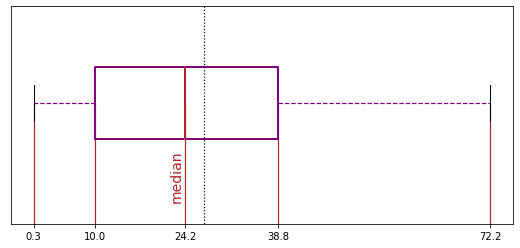

In [45]:
fig = plt.figure(1, figsize=(9, 4))
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 14})

medianprops = dict(linestyle='-', linewidth=2, color='firebrick')
boxprops = dict(linestyle='-', linewidth=2, color='purple')
whiskerprops = dict(linestyle='--', linewidth=1.2, color='purple')
# whiskertips = dict(linestyle='-', linewidth=2, color='purple')

ax.boxplot(df["reduction"], vert=False, manage_ticks=True, 
           medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops)
ax.set_yticks([])
ax.set_yticklabels([])


quantiles = np.quantile(np.round(df["reduction"],1), np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
          color='firebrick', ls='-', lw=1.2, zorder=0)

ax.set_ylim([0.75, 1.2])
ax.vlines(df["reduction"].mean(), 0, 2, linewidth=1.2, ls=':', color='k')
ax.set_xticks(np.round(quantiles, 1))



plt.annotate(xy=(quantiles[2] - 2.5, 0.8), text='median', rotation=90, color='firebrick')

plt.savefig("/home/dee/dev/deptrim-major/deptrim-experiments/pipeline/projects/jar-sizes.jpg")
plt.show()
